Support Classification & Topic Modeling
===

Jurgens Project site: https://blablablab.si.umich.edu/projects/support/

Jurgens Paper: https://www.aclweb.org/anthology/D18-1004

In [1]:
%matplotlib inline

from pathlib import Path
import os
import subprocess

import pandas as pd
import numpy as np

from collections import Counter
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib
import pylab as pl
from IPython.core.display import display, HTML

import sklearn
import sklearn.model_selection
import sklearn.linear_model
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline

import spacy

import pyLDAvis
import pyLDAvis.gensim

### Training & Annotation Data
On new machines, run `download_support_annotations.sh` and download `github.com/davidjurgens/support/blob/master/data/training-data.with-ids.tsv`.

In [3]:
# get data
git_root_dir = !git rev-parse --show-toplevel
git_root_dir = Path(git_root_dir[0].strip())
data_dir = git_root_dir / 'support_classification' / 'data'
crowdflower_support_annotations_file = data_dir / 'crowdflower-support-annotations.csv'
training_data_file = data_dir / 'training-data.with-ids.tsv'
assert data_dir.exists() and crowdflower_support_annotations_file.exists() and training_data_file.exists() 

In [5]:
df = pd.read_csv(training_data_file, sep='\t')
len(df)

9030

In [6]:
df.head()

,agreement,offensiveness,politeness,support,post,reply,post_id,reply_id,source,platform
0,3.000000,1.000000,3.000000,3.000000,Well that didnt take long,What didnt?,cj4hzgi,cj4i1cc,reddit-worldnews-2014,reddit
1,3.000000,1.333333,3.333333,3.000000,Im always amused when Im flying home and there...,and what people think is Vegas is really Paradise,csvv5j9,csvy89s,reddit-pics-2015,reddit
2,2.333333,1.000000,3.000000,3.000000,"There was no absence of regulation back then, ...",Which back when? Im no ballerina but I dont th...,cswfklp,cswktwq,reddit-todayilearned-2015,reddit
3,4.333333,3.000000,2.000000,3.666667,**YEA** but he had calvin johnson so that mean...,EXACTLY! To all the Bears fans who say this...,c5c1eur,c5c1q9f,reddit-nfl-2012,reddit
4,3.000000,3.000000,2.333333,3.000000,Maybe it shouldnt be as easy as Arya made it seem,well when you have magical face changing power...,dkbgylh,dkbhbxt,reddit-asoiaf-2017,reddit


In [7]:
Counter(df.platform).most_common()

[('reddit', 3015), ('stackexchange', 3013), ('wiki', 2996), ('?', 6)]

In [8]:
Counter([str(source).split("-")[0] for source in df.source]).most_common()

[('reddit', 3015),
 ('stackexchange', 3013),
 ('wikin', 1652),
 ('wiki', 1344),
 ('?', 6)]

In [9]:
df['source_site'] = [str(source).split("-")[0] for source in df.source]

In [10]:
Counter(df.support).most_common()

[(3.0, 3787),
 (3.33333333333, 1823),
 (2.66666666667, 1448),
 (3.66666666667, 738),
 (2.33333333333, 577),
 (4.0, 303),
 (2.0, 175),
 (4.33333333333, 72),
 (1.6666666666699999, 68),
 (1.33333333333, 20),
 (4.66666666667, 11),
 (1.0, 4),
 (5.0, 2),
 (2.75, 1),
 (3.5, 1)]

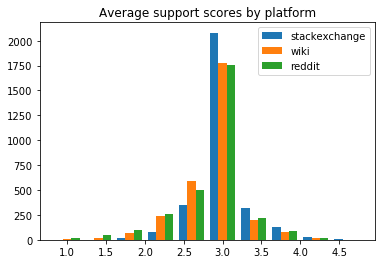

In [11]:
xs = []
labels = []
for platform in set(df.platform):
    if platform == '?':
        continue
    x = df[df.platform == platform].support
    xs.append(x)
    labels.append(platform)
plt.hist(xs, label=labels, align='left')
plt.legend()
plt.title("Average support scores by platform")
plt.show()

### Preprocessing with Spacy
Only run commented on new machines; training data is already pre-processed in the `data` dir otherwise.

In [12]:
%%time
nlp = spacy.load('en_core_web_lg')

CPU times: user 8.3 s, sys: 988 ms, total: 9.29 s
Wall time: 9.28 s


In [13]:
#tokens = []
#embedding = []
#for doc in tqdm(nlp.pipe(df.reply, batch_size=1000, n_threads=3)):
#    tokens.append([token.text for token in doc])
#    embedding.append(doc.vector)

In [14]:
#df['tokens'] = tokens
#df['embedding'] = embedding
#df.reset_index(inplace=True)

In [15]:
#df.to_pickle(data_dir / 'tokenized_training.pkl')

In [16]:
df = pd.read_pickle(data_dir / 'tokenized_training.pkl')
len(df)

9030

In [17]:
df.tokens.head()

0                                   [What, did, nt, ?]
1    [and, what, people, think, is, Vegas, is, real...
2    [Which, back, when, ?, I, m, no, ballerina, bu...
3    [EXACTLY, !,    , To, all, the, Bears, fans, w...
4    [well, when, you, have, magical, face, changin...
Name: tokens, dtype: object

In [18]:
df.embedding.head()

0    [-0.06969675, 0.21982999, -0.07316275, -0.4447...
1    [-0.091369994, 0.31280944, -0.14858837, -0.336...
2    [0.09055326, 0.109529115, -0.13828273, -0.1614...
3    [-0.064493835, 0.20588325, -0.17942156, -0.104...
4    [-0.097393975, 0.14301756, -0.20241255, -0.029...
Name: embedding, dtype: object

### Classification with VW
#### Tune the Model

In [11]:
def map_support_to_label(support):
    if support <= -0.67:
        return 1  # Unsupportive
    elif support >= 0.67:
        return 3  # Supportive
    else:
        return 2  # Neutral

def map_support_to_binary_label(support):
    # Assign positive if between 1 and 2
    if support > 0.67:
        return 1
    else:
        return 0

In [20]:
# shuffle the data
df = df.sample(frac=1).reset_index(drop=True)

In [21]:
# add discretized support label to the data
df['support_discretized'] = [map_support_to_label(s - 3) for s in df.support]
Counter(df.support_discretized).items()

dict_items([(2, 8375), (3, 388), (1, 267)])

In [22]:
df = df[df.support_discretized != 1].copy().reset_index(drop=True)
df['support_discretized'] -= 2

In [23]:
Counter(df.support_discretized).items()

dict_items([(0, 8375), (1, 388)])

In [24]:
df[['support_discretized', 'tokens']].head()

,support_discretized,tokens
0,0,"[:, Did, your, way, of, checking, take, into, ..."
1,0,"[This, assertion, is, obviously, incorrect, .,..."
2,0,"[Sounds, like, that, site, could, work, some, ..."
3,0,"[Not, particularly, ., A, few, minor, points, ..."
4,0,"[This, should, probably, be, addressed, in, th..."


In [7]:
# cannot pickle lambda functions so we use an identity function instead
def I(x):
    return x

In [39]:
text_clf = Pipeline([
     ('vect', CountVectorizer(ngram_range=(1,2), min_df=3, 
                              tokenizer=I, 
                              preprocessor=I)),
     ('tfidf', TfidfTransformer()),
     ('clf', sklearn.linear_model.SGDClassifier(loss='log', alpha=0.001, tol=1e-3, max_iter=5000, penalty='elasticnet') ),
])

In [40]:
#text_clf.steps[2][1].get_params()

In [41]:
gridsearch_autotune = True

In [42]:
if gridsearch_autotune:
    param_grid = {'clf__alpha':[0.1, 0.01, 0.001, 0.0001, 0.00001],
             'clf__epsilon':[1, 0.1, 0.01, 0.001, 0.0001],
             'clf__l1_ratio':[.1, .15, .2, .25, .5],
             'clf__tol':[.1, .01, .001, .0001, .00001]}
    grid_clf = sklearn.model_selection.GridSearchCV(text_clf, param_grid, cv=10)
    
    train = df.sample(frac=.9)
    test = df[~df.index.isin(train.index)]
    
    #downsample HERE
    neutral_idx = train[train.support_discretized == 0].sample(n=400).index
    neutral_total = len(neutral_idx)
    supportive_idx = train[train.support_discretized == 1].index
    supportive_total = len(supportive_idx)
    train_subset_idx = neutral_idx.union(supportive_idx)
    train_subset = train.loc[train_subset_idx]
    
    tuned_clf = grid_clf.fit(train_subset.tokens, train_subset.support_discretized)
    
    y_pred_train = tuned_clf.predict(train_subset.tokens)
    y_pred_test = tuned_clf.predict(test.tokens)
    acc_train = np.sum(y_pred_train == train_subset.support_discretized) / len(y_pred_train)
    acc_test = np.sum(y_pred_test == test.support_discretized) / len(y_pred_test)
    neutral_proportion = Counter(y_pred_train)[0] / len(y_pred_train)
    neutral_true_proportion = Counter(train_subset.support_discretized)[0] / len(train_subset)
    print(f"Train: {acc_train*100:.2f}%\t test: {acc_test*100:.2f}%\t{neutral_proportion*100:.2f}% guess\t {neutral_true_proportion*100:.2f}% true")
else:
    kf = sklearn.model_selection.KFold(n_splits=20)
    for train_idx, test_idx in kf.split(df):
        train = df.loc[train_idx]
        test = df.loc[test_idx]

        #downsample HERE
        neutral_idx = train[train.support_discretized == 0].sample(n=400).index
        neutral_total = len(neutral_idx)

        supportive_idx = train[train.support_discretized == 1].index
        supportive_total = len(supportive_idx)

        train_subset_idx = neutral_idx.union(supportive_idx)
        train_subset = train.loc[train_subset_idx]

        tuned_clf = text_clf.fit(train_subset.tokens, train_subset.support_discretized)

        y_pred_train = tuned_clf.predict(train_subset.tokens)
        y_pred_test = tuned_clf.predict(test.tokens)
        acc_train = np.sum(y_pred_train == train_subset.support_discretized) / len(y_pred_train)
        acc_test = np.sum(y_pred_test == test.support_discretized) / len(y_pred_test)
        neutral_proportion = Counter(y_pred_train)[0] / len(y_pred_train)
        neutral_true_proportion = Counter(train_subset.support_discretized)[0] / len(train_subset)
        print(f"Train: {acc_train*100:.2f}%\t test: {acc_test*100:.2f}%\t{neutral_proportion*100:.2f}% guess\t {neutral_true_proportion*100:.2f}% true")

Train: 86.02%	 test: 80.48%	59.68% guess	 53.76% true


In [43]:
import joblib
joblib.dump(grid_clf, os.path.join("/home/lana/shared/caringbridge/data/projects/sna-social-support/support_modeling", "support_classifier.sav"))

['/home/lana/shared/caringbridge/data/projects/sna-social-support/support_modeling/support_classifier.sav']

#### Run it on Guestbooks

In [27]:
#output_data_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/support_modeling"
#gbs = pd.read_hdf(os.path.join(output_data_dir, 'gb_sample_1000000_021220.h5'), key='gb_sample')
#len(gbs)

In [28]:
#gbs.head(n=2)

Only run on new samples! Large samples should be submitted to PBS.

In [29]:
#tokens = []
#for doc in tqdm(nlp.pipe(gbs.body_text, batch_size=25000, n_threads=16), total=1000000, position=False):
#    tokens.append([token.text for token in doc])
#gbs['tokens'] = tokens

In [30]:
#gbs.to_pickle(data_dir / 'tokenized_gb_1000000.pkl')

In [8]:
import joblib
md = joblib.load(os.path.join("/home/lana/shared/caringbridge/data/projects/sna-social-support/support_modeling", "support_classifier.sav"))

In [4]:
gbs = pd.read_hdf(data_dir / 'tokenized_gb_1000000.h5')
len(gbs)

1000000

In [ ]:
train = df
neutral_idx = train[train.support_discretized == 0].sample(n=400).index
neutral_total = len(neutral_idx)
supportive_idx = train[train.support_discretized == 1].index
supportive_total = len(supportive_idx)
train_subset_idx = neutral_idx.union(supportive_idx)
train_subset = train.loc[train_subset_idx]
md = tuned_clf.fit(train_subset.tokens, train_subset.support_discretized)
y_pred_train = md.predict(train_subset.tokens)
acc_train = np.sum(y_pred_train == train_subset.support_discretized) / len(y_pred_train)
acc_train

In [12]:
gbs_predicted = md.predict(gbs.tokens)
gbs['pred_label'] = gbs_predicted
for label, count in Counter(gbs_predicted).most_common():
    print(label, count)

1 751645
0 248355


In [13]:
gbs_score_predicted = md.predict_proba(gbs.tokens)
gbs['pred_prob_neutral'] = gbs_score_predicted[:,0]
gbs['pred_prob_supportive'] = gbs_score_predicted[:,1]

In [14]:
gbs_score_predicted

array([[0.36135927, 0.63864073],
       [0.19378608, 0.80621392],
       [0.19490235, 0.80509765],
       ...,
       [0.51768795, 0.48231205],
       [0.13655766, 0.86344234],
       [0.21593439, 0.78406561]])

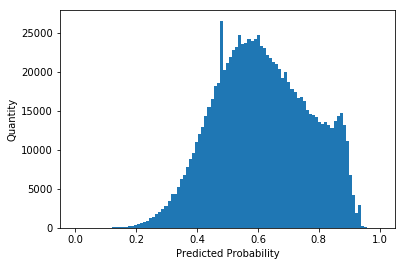

In [15]:
plt.hist(gbs_score_predicted[:,1], bins=np.linspace(0, 1, num=100))
plt.ylabel("Quantity")
plt.xlabel("Predicted Probability")
plt.show()

In [16]:
gbs['support_discretized'] = (gbs['pred_prob_supportive'] >= .67)

In [38]:
#for row in gbs[[
#    'site_id', 'created_at', 'site_index', 
#   'pred_label', 'pred_prob_neutral', 
#    'pred_prob_supportive', 'body_text']].sort_values(
#    by='pred_prob_supportive', ascending=False
#).head(n=10).itertuples():
#    print(row.pred_prob_supportive)
#    print(row.body_text)
#    print()

In [38]:
#for row in gbs[[
#    'site_id', 'created_at', 'site_index', 
#    'pred_label', 'pred_prob_neutral', 
#    'pred_prob_supportive', 'body_text']].sort_values(
#    by='pred_prob_supportive', ascending=True
#).head(n=10).itertuples():
#    print(row.pred_prob_supportive)
#    print(row.body_text)
#    print()

In [39]:
gbs.to_hdf('data/classified_gbs.h5', key='gbs')

/home/srivbane/shared/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:2530: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->['int_type', 'journal_oid', 'body_text', 'tokens']]

  pytables.to_hdf(path_or_buf, key, self, **kwargs)


### Topic Modeling with LDA
For larger samples, I have a job script to do the modeling, which we can load from memory

In [18]:
import gensim
import logging
# gensim has an annoying feature that all of its output is produced via logging, so we have to set that up to get feedback on training
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

/home/srivbane/shared/anaconda3/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [21]:
saved_data_dir = "/home/lana/shared/caringbridge/data/projects/sna-social-support/support_modeling"
lda = gensim.models.LdaModel.load(os.path.join(saved_data_dir, "lda/gb_1000000_lda_100t.model"))
dct = gensim.corpora.Dictionary.load(os.path.join(saved_data_dir, "lda/gb_100t_dict.pkl"))

2020-04-07 11:51:45,130 : INFO : loading LdaModel object from /home/lana/shared/caringbridge/data/projects/sna-social-support/support_modeling/lda/gb_1000000_lda_100t.model
2020-04-07 11:51:45,134 : INFO : loading expElogbeta from /home/lana/shared/caringbridge/data/projects/sna-social-support/support_modeling/lda/gb_1000000_lda_100t.model.expElogbeta.npy with mmap=None
2020-04-07 11:51:45,162 : INFO : setting ignored attribute state to None
2020-04-07 11:51:45,163 : INFO : setting ignored attribute dispatcher to None
2020-04-07 11:51:45,164 : INFO : setting ignored attribute id2word to None
2020-04-07 11:51:45,165 : INFO : loaded /home/lana/shared/caringbridge/data/projects/sna-social-support/support_modeling/lda/gb_1000000_lda_100t.model
2020-04-07 11:51:45,165 : INFO : loading LdaState object from /home/lana/shared/caringbridge/data/projects/sna-social-support/support_modeling/lda/gb_1000000_lda_100t.model.state
2020-04-07 11:51:45,313 : INFO : loaded /home/lana/shared/caringbridge/

In [41]:
#dct = gensim.corpora.Dictionary(gbs.tokens)
#len(dct)

In [42]:
#prev_size = len(dct)
#dct.filter_extremes(no_below=5, no_above=0.2)
#new_size = len(dct)
#print(f"Removed {prev_size - new_size} dictionary entries. New size: {new_size}")

In [43]:
#lda = gensim.models.LdaMulticore(corpus, id2word=dct, num_topics=30, passes=10, chunksize=10000)

In [22]:
corpus = [dct.doc2bow(sentence) for sentence in tqdm(gbs.tokens, position=False) if len(sentence) > 2]
len(corpus)

100%|██████████| 1000000/1000000 [01:01<00:00, 16207.56it/s]


996189

In [23]:
dropped = [i for i, row in tqdm(gbs.iterrows(), position=False) if len(row.tokens) <= 2]

1000000it [02:06, 7917.70it/s]


In [ ]:
#prepared_data = pyLDAvis.gensim.prepare(lda, corpus, dct)

In [ ]:
#pyLDAvis.save_html(prepared_data, "lda_vis.html")

#### Representative Documents

In [8]:
representative_idx = {x : [] for x in range(1,101)} # {topic : [(idx, prob)... ]}
for i, doc in tqdm(enumerate(corpus), total=1000000):
    for tup in lda.get_document_topics(doc, minimum_probability=0):
        # if this_probability > representative_probability
        if tup[1] > 0.9:
            representative_idx[tup[0]+1].append((i, tup[1]))

100%|█████████▉| 996189/1000000 [23:03<00:05, 720.11it/s]


In [9]:
representative_topics = {x : [] for x in range(1,101)}
for k in representative_idx.keys():
    for tup in representative_idx[k]:
        i, p = tup
        representative_topics[k].append(gbs.iloc[i].body_text)

Handpick representatives from anything above a prob of 90%

In [12]:
with open("data/representatives.txt", 'w+') as record:
    for topic in representative_topics.keys():
        record.write(f"TOPIC {topic}: \n")
        for doc in representative_topics[topic]:
            record.write(f"{doc}\n-----\n")
        record.write("\n------------------------------\n")

### Topic Modeling and Support Correlation
##### Continous v. Continous

In [69]:
gbs_copy = gbs.copy().drop(dropped).reset_index()

In [60]:
f = []
for doc in corpus:
    topic_probs = lda.get_document_topics(doc, minimum_probability=0)
    f.append([x[1] for x in topic_probs])
df = pd.DataFrame(f)
len(df)

996189

In [70]:
df['support'] = gbs_copy['pred_prob_supportive']

In [72]:
import scipy
stats = []
for i in range(0,100):
    corr = scipy.stats.pearsonr(df[i], df['support'])
    stats.append(corr)
corr_cc_df = pd.DataFrame(stats, index=range(1,101), columns=["R", "p"]).round(3)
corr_cc_df.style.apply(lambda x: ["background: yellow" if abs(v) > .9 else "" for v in x], axis = 1, subset=["R"])
corr_cc_df.style.apply(lambda x: ["background: yellow" if abs(v) < (0.05 / 30) else "" for v in x], axis = 1, subset = ["p"])
corr_cc_df.T

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
R,0.009,-0.067,-0.017,-0.121,0.029,0.067,0.023,-0.148,0.008,-0.001,...,-0.011,0.053,0.034,-0.014,-0.145,0.107,-0.003,0.024,-0.141,0.027
p,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.173,...,0.000,0.000,0.000,0.000,0.000,0.000,0.011,0.000,0.000,0.000


In [73]:
print(f"[C-C] Avg R: {np.mean(corr_cc_df.R)}\t Avg p-val: {np.mean(corr_cc_df.p)}")

[C-C] Avg R: -0.0006399999999999993	 Avg p-val: 0.00336


##### Other measures

In [94]:
f = []
for doc in tqdm(corpus, position=False):
    topic_probs = sorted(lda.get_document_topics(doc, minimum_probability=0), key = lambda x: x[1], reverse=True)
    assigned = topic_probs[0][0]
    f.append(assigned)
df = pd.DataFrame(f, columns=['topic'])
df['support'] = gbs_copy['pred_prob_supportive']

100%|██████████| 996189/996189 [19:57<00:00, 831.72it/s]


In [97]:
rdd, pdd = scipy.stats.pearsonr(f, gbs_copy['support_discretized'].values[:len(f)])
rdc, pdc = scipy.stats.pearsonr(f, gbs_copy['pred_prob_supportive'].values[:len(f)])

In [98]:
print(f"[D-D] Avg R: {rdd}\t Avg p-val: {pdd}")
print(f"[D-C] Avg R: {rdc}\t Avg p-val: {pdc}")

[D-D] Avg R: 0.002373331776323387	 Avg p-val: 0.01784563833800888
[D-C] Avg R: -0.009924630749299168	 Avg p-val: 3.92291908684619e-23


## For Thesis

In [24]:
gbs.head()

,user_id,site_id,int_type,created_at,updated_at,journal_oid,site_index,is_nontrivial,is_self_interaction,body_text,tokens,pred_label,pred_prob_neutral,pred_prob_supportive,support_discretized
540271,355936,11900,guestbook,1184103659000,1184103659000,,-1.0,True,False,"For all the help the medical community can be,...","[For, all, the, help, the, medical, community,...",1,0.361359,0.638641,False
3609373,1884841,119180,guestbook,1251075969000,1251075969000,,-1.0,True,False,Kylee: I love the story. Next time just try ...,"[Kylee, :, , I, love, the, story, ., , Nex...",1,0.193786,0.806214,True
4325045,1195944,55715,guestbook,1197856577000,1197856577000,,-1.0,True,False,What an honor to be the very first person to s...,"[What, an, honor, to, be, the, very, first, pe...",1,0.194902,0.805098,True
5414881,6773640,57152,guestbook,1301181775000,1301181775000,,-1.0,True,False,"Home is the best place to be, think about you ...","[Home, is, the, best, place, to, be, ,, think,...",0,0.569621,0.430379,False
1726463,15515585,186646,guestbook,1335786062000,1335786062000,,-1.0,True,False,I was reading the words - we can never go back...,"[I, was, reading, the, words, -, we, can, neve...",0,0.546823,0.453177,False


In [45]:
prime_topic = []
d = 0
ri = 0
for i, row in tqdm(gbs.iterrows(), total=len(gbs)):
    if i in dropped:
        prime_topic.append(-1)
        d+=1
    else:
        topic_probs = sorted(lda.get_document_topics(corpus[ri - d], minimum_probability=0), key = lambda x: x[1], reverse=True)
        prime_topic.append(topic_probs[0][0])
    ri += 1
gbs['prime_topic'] = prime_topic

100%|██████████| 1000000/1000000 [23:34<00:00, 707.02it/s]


In [46]:
avg_support_by_topic = []
for i in range(1,100):
    this = gbs[gbs.prime_topic == i]
    avg_support_by_topic.append(np.mean(this.pred_prob_supportive))

In [49]:
for i, stat in enumerate(avg_support_by_topic):
    print(f"{i+1}: {100*stat:.2f}%")

0: 46.26%
1: 53.49%
2: 55.83%
3: 67.15%
4: 67.18%
5: 65.02%
6: 53.12%
7: 62.02%
8: 57.02%
9: 62.29%
10: 57.49%
11: 60.41%
12: 58.86%
13: 58.93%
14: 61.10%
15: 51.45%
16: 57.71%
17: 62.29%
18: 63.19%
19: 61.09%
20: 63.29%
21: 64.77%
22: 54.55%
23: 56.96%
24: 70.89%
25: 60.35%
26: 57.07%
27: 68.52%
28: 49.88%
29: 68.09%
30: 55.50%
31: 60.93%
32: 59.21%
33: 58.71%
34: 72.11%
35: 64.76%
36: 64.77%
37: 62.82%
38: 64.86%
39: 58.58%
40: 68.87%
41: 59.23%
42: 65.48%
43: 66.45%
44: 70.60%
45: 65.90%
46: 55.74%
47: 66.40%
48: 66.94%
49: 59.34%
50: 65.22%
51: 60.42%
52: 69.51%
53: 66.74%
54: 62.23%
55: 62.98%
56: 59.00%
57: 65.63%
58: 62.55%
59: 67.36%
60: 62.61%
61: 62.11%
62: 65.84%
63: 57.70%
64: 64.91%
65: 50.96%
66: 54.93%
67: 58.36%
68: 56.25%
69: 62.46%
70: 46.28%
71: 57.00%
72: 65.13%
73: 53.76%
74: 63.38%
75: 65.90%
76: 61.30%
77: 58.37%
78: 64.03%
79: 61.43%
80: 70.78%
81: 63.51%
82: 67.12%
83: 62.06%
84: 60.65%
85: 49.93%
86: 78.25%
87: 64.27%
88: 63.47%
89: 55.65%
90: 64.68%
91: 69.24